# CKA Similarity Analysis
In this notebook we explore the CKA similarity metric with quantized models.

In [27]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings


# import modules from JTAG model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from model import JetTagger
from jet_datamodule import JetDataModule

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA



## Utility methods

In [28]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()


In [29]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
cka_batch_num = 50000

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [30]:
DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']
# we do not consider extreme low precisions due to their performances
precisions = [3, 4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [31]:
def get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size, num_tests=3):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    EMDs = []
    min_emd = 1000
    min_emd_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'ECON_{precision}b/{size}/{size}_emd_{i}.txt'
        try:
            emd_file = open(file_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            EMDs.append(emd)
            if min_emd >= emd:
                min_emd = emd
                min_emd_index = i
            emd_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(EMDs) == 0:
        # warnings.warn(f"Attention: There is no EMD value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}")
        return
    
    return mean(EMDs), min_emd_index


def get_emd_with_noise(batch_size, learning_rate, precision, size, noise_type, percentage):
    '''
    Return the EMD achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'ECON_{precision}b/{size}/{size}_emd_{noise_type}_{percentage}.txt'
    noise_emd = -1
    try:
        emd_file = open(file_path)
        emd_text = emd_file.read()
        if not emd_text.startswith('['):
            noise_emd = float(emd_text)
        else:
            emd = ast.literal_eval(emd_text)
            noise_emd = emd[0]['AVG_EMD']
        emd_file.close()
    except Exception as e:
        warnings.warn("Warning: " + file_path + " not found!")
        return -1
    return noise_emd


def load_model(batch_size, learning_rate, precision, size):
    '''
    Method used to get the model and the relative EMD value
    '''
    emd, idx = get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_{idx}_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, emd


def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = AutoEncoderDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module


def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      size,
                      dataloader,
                      activation_layers=ECON_layers,
                      max_batches=cka_batch_num):
    # load the model
    model, _ = load_model(batch_size, learning_rate, precision, size)
    
    # init the metric
    cka = CKA(model, 
              dataloader, 
              layers=activation_layers,
              max_batches=max_batches)
    
    return cka


def compute_distance(cka, batch_size, learning_rate, precision, size, load=True):
    # check if distance already computed
    if load:
        cka.name = f'distance_{size}_bs{batch_size}_lr{learning_rate}_p{precision}'
        if cka.load_from_file(DATA_PATH):
            return cka.results
        
    model, _ = load_model(batch_size, learning_rate, precision, size)
    # compute the difference
    result = cka.compare(model, cka.layers)
    cka.save_on_file(path=DATA_PATH)
    
    return result

## Result

In [32]:
# During the computation of the CKA similarity both the model must process the same data, 
# so we create a cka_dataloader equal for all the models which we will use to carry on our
# test
cka_dataloader = get_data_module(16).test_dataloader()

noise_type = 'gaussian'
noise = 5 # 5 10 15 20

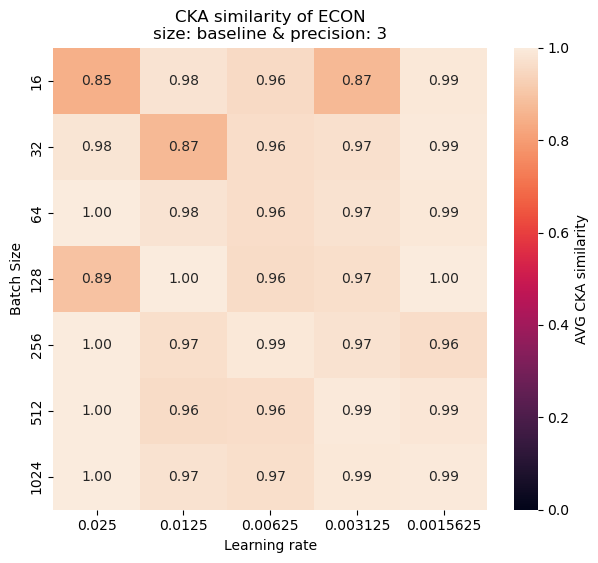

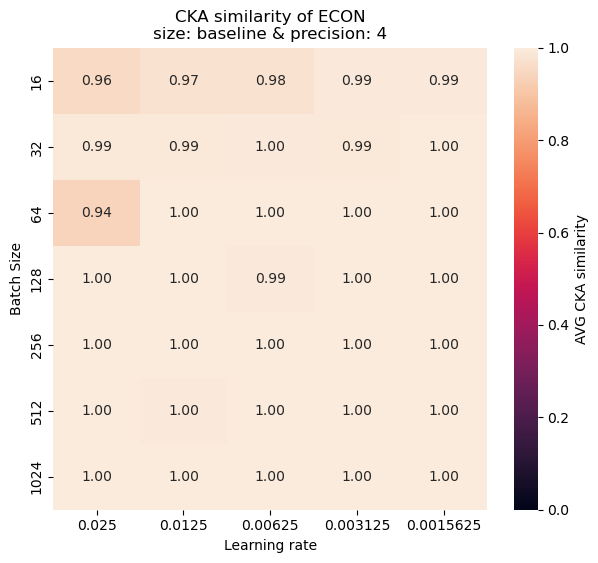

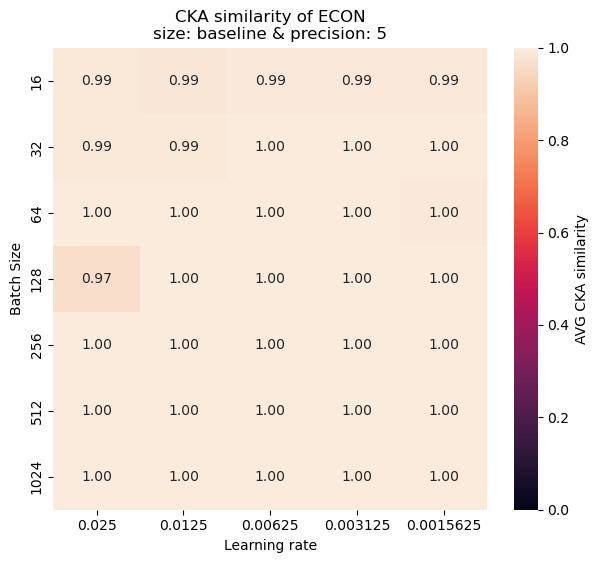

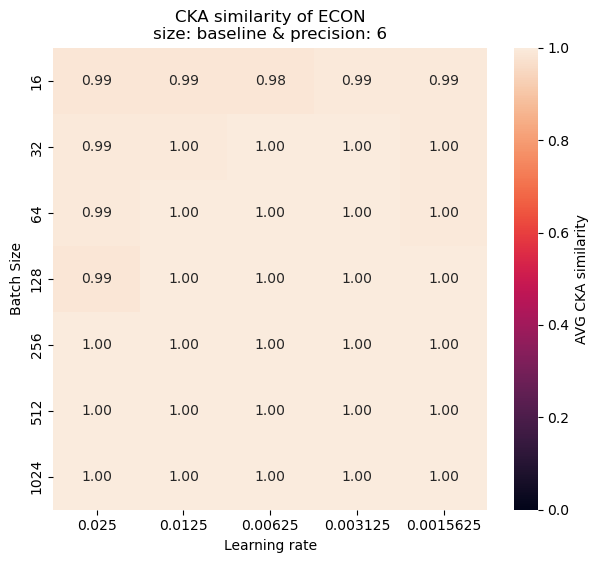

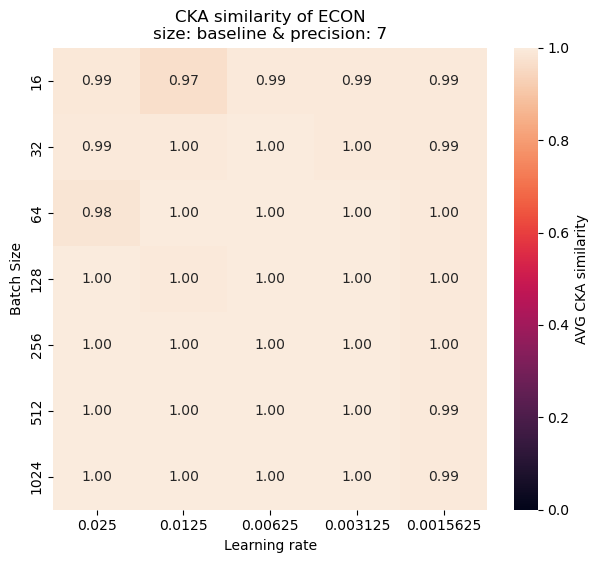

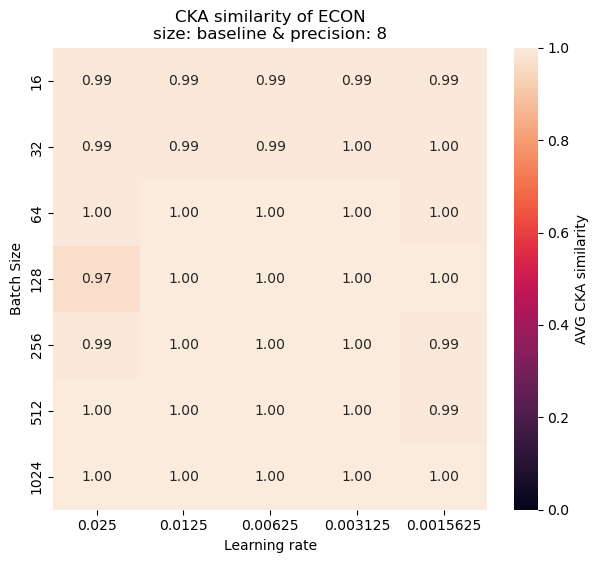

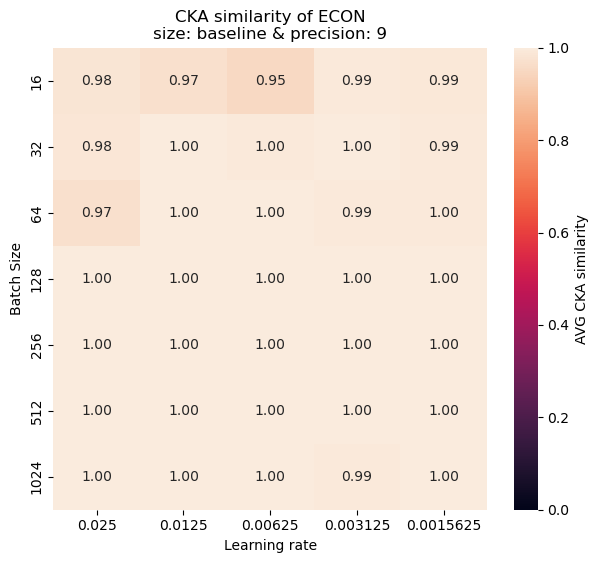

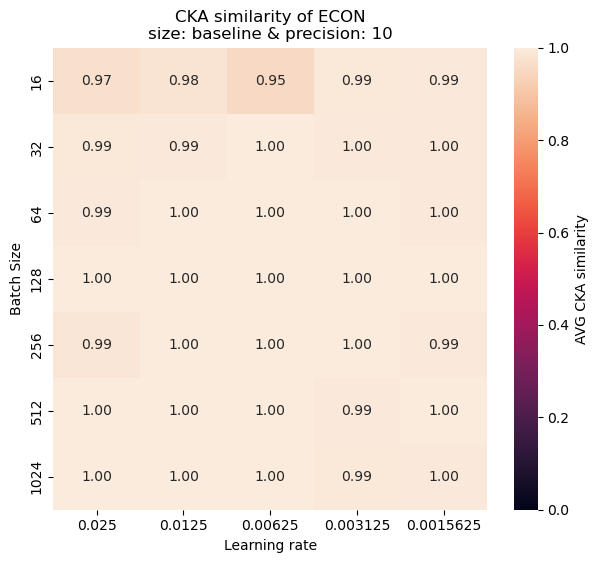

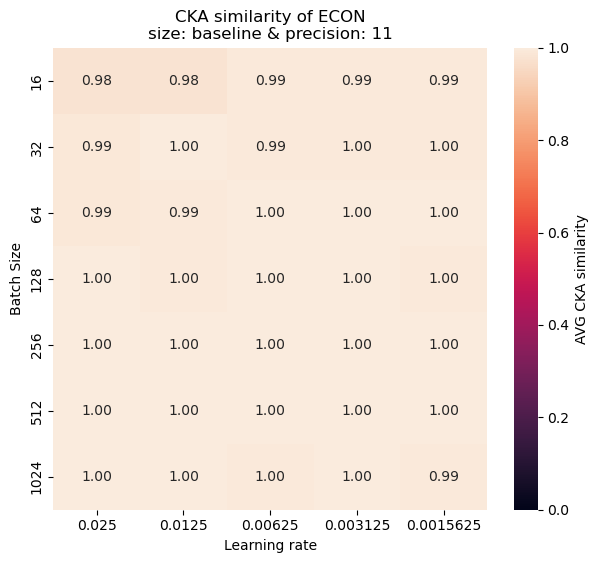

In [33]:
cka_distribution = []
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get the performance of the model with and without noise
            mean_emd, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            noise_emd = get_emd_with_noise(bs, lr, p, size, noise_type, noise)
            # path to the directory
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            # get the metric
            cka = get_cka_per_model(bs,
                                    lr,
                                    p,
                                    size,
                                    cka_dataloader,
                                    ECON_layers,
                                    max_batches=cka_batch_num)
            
            # load the results
            avg_cka = -1
            if cka.load_from_file(path):
                result = cka.results['internal_cka'].detach().cpu().numpy()
                avg_cka = (np.sum(result) - np.sum(result.diagonal())) \
                                / (result.shape[0]**2 - result.shape[0])

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
            # build the dataframe for further analysis
            cka_distribution.append({
                'precision': p, 
                'avg_cka': avg_cka,
                'emd': mean_emd,
                'noise_emd': noise_emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd - mean_emd) * 100 / mean_emd,
            })
            
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity',
                    cmap='rocket')

In [34]:
cka_distribution_df = pd.DataFrame(cka_distribution)

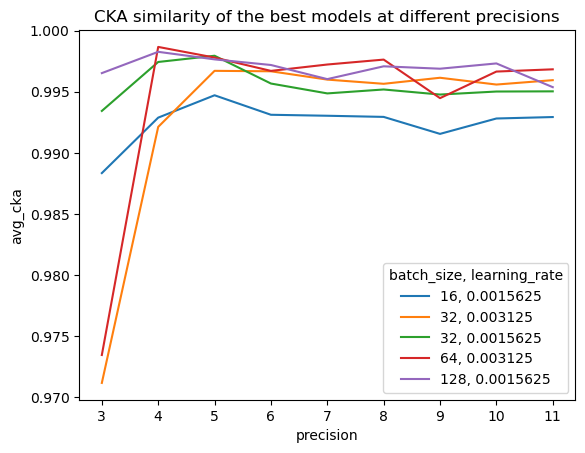

In [35]:
top_5_df = cka_distribution_df.loc[
        (cka_distribution_df.batch_size == '32') & (cka_distribution_df.learning_rate == '0.003125') |
        (cka_distribution_df.batch_size == '128') & (cka_distribution_df.learning_rate == '0.0015625') |
        (cka_distribution_df.batch_size == '32') & (cka_distribution_df.learning_rate == '0.0015625') |
        (cka_distribution_df.batch_size == '16') & (cka_distribution_df.learning_rate == '0.0015625') |
        (cka_distribution_df.batch_size == '64') & (cka_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='avg_cka', hue=hue)
plt.title("CKA similarity of the best models at different precisions")
plt.show()

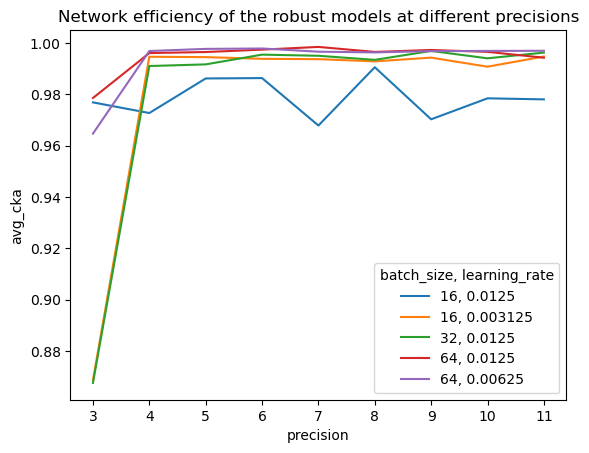

In [36]:
top_5_df = cka_distribution_df.loc[
        (cka_distribution_df.batch_size == '16') & (cka_distribution_df.learning_rate == '0.003125') |
        (cka_distribution_df.batch_size == '64') & (cka_distribution_df.learning_rate == '0.00625') |
        (cka_distribution_df.batch_size == '16') & (cka_distribution_df.learning_rate == '0.0125') |
        (cka_distribution_df.batch_size == '32') & (cka_distribution_df.learning_rate == '0.0125') |
        (cka_distribution_df.batch_size == '64') & (cka_distribution_df.learning_rate == '0.0125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='avg_cka', hue=hue)
plt.title("Network efficiency of the robust models at different precisions")
plt.show()

## Per layer analysis

In [37]:
MIN_EMD = 3
MAX_LOSS = 50
NUM_PLOT = 3

cka_distribution_df = cka_distribution_df.loc[
        (cka_distribution_df.loss > -0.5) & 
        (cka_distribution_df.emd < MIN_EMD) # &
        # (ne_distribution_df.loss < MAX_LOSS)
    ]
cka_distribution_df.sort_values(by='loss', ascending=True, inplace=True)

--------------------------------------------------------------------------------
Low loss
EMD:	1.7443809111913045
Loss:	-0.2568909484347166
AVG CKA similarity:	0.9993391036987305


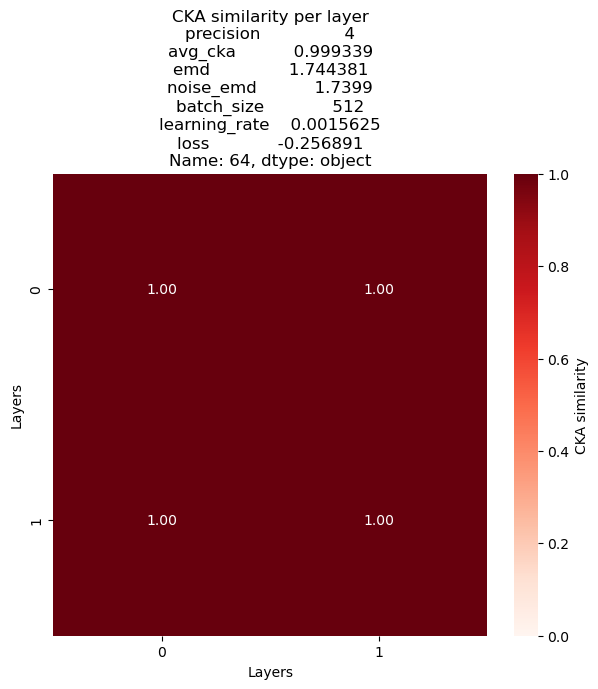

--------------------------------------------------------------------------------
Low loss
EMD:	1.860877513885498
Loss:	3.1380067876381372
AVG CKA similarity:	0.8685701489448547


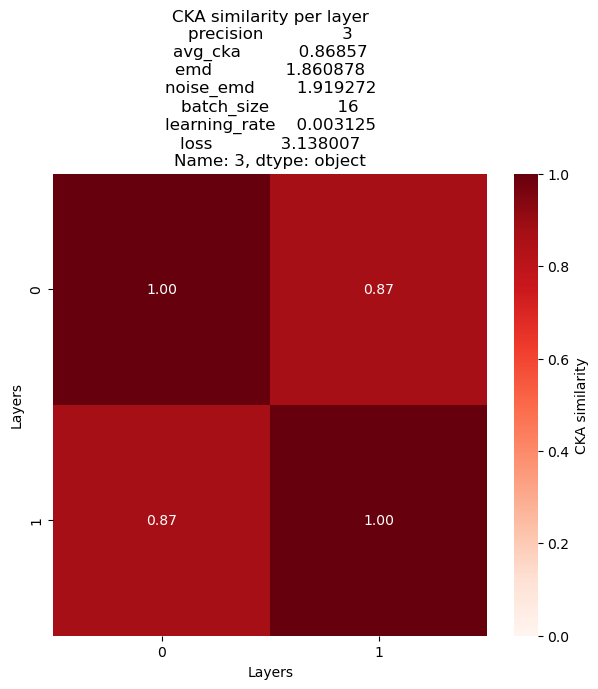

--------------------------------------------------------------------------------
Low loss
EMD:	1.9190647999445598
Loss:	4.798360785779066
AVG CKA similarity:	0.96470046043396


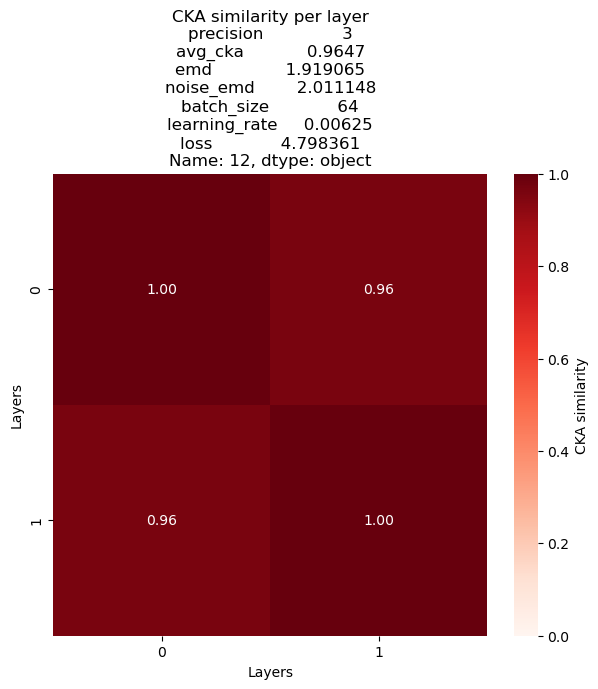

In [38]:
best_df = cka_distribution_df.head(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    
    path = os.path.join(
        DATA_PATH,
        f"bs{best_df.iloc[i]['batch_size']}_lr{best_df.iloc[i]['learning_rate']}" \
        f"/ECON_{best_df.iloc[i]['precision']}b/{size}/"
    )
    cka = get_cka_per_model(int(best_df.iloc[i]['batch_size']),
                            float(best_df.iloc[i]['learning_rate']), 
                            int(best_df.iloc[i]['precision']),
                            size,
                            cka_dataloader,
                            max_batches=cka_batch_num)
    if cka.load_from_file(path):
        results = cka.results
    else:
        results = cka.compute()
        
    print(f"EMD:\t{best_df.iloc[i]['emd']}\n" \
          f"Loss:\t{best_df.iloc[i]['loss']}\n" \
          f"AVG CKA similarity:\t{best_df.iloc[i]['avg_cka']}")
    
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{best_df.iloc[i]}", 
                    scale_label='CKA similarity',
                    cmap='Reds')


--------------------------------------------------------------------------------
Low loss
EMD:	1.3663277626037598
Loss:	252.22089644122613
AVG CKA similarity:	0.9986920356750488


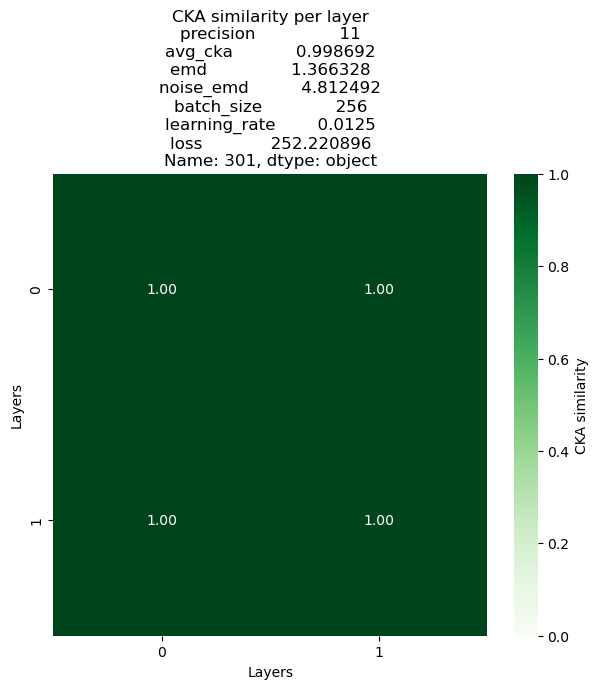

--------------------------------------------------------------------------------
Low loss
EMD:	1.1998576720555623
Loss:	269.65530552378385
AVG CKA similarity:	0.99847412109375


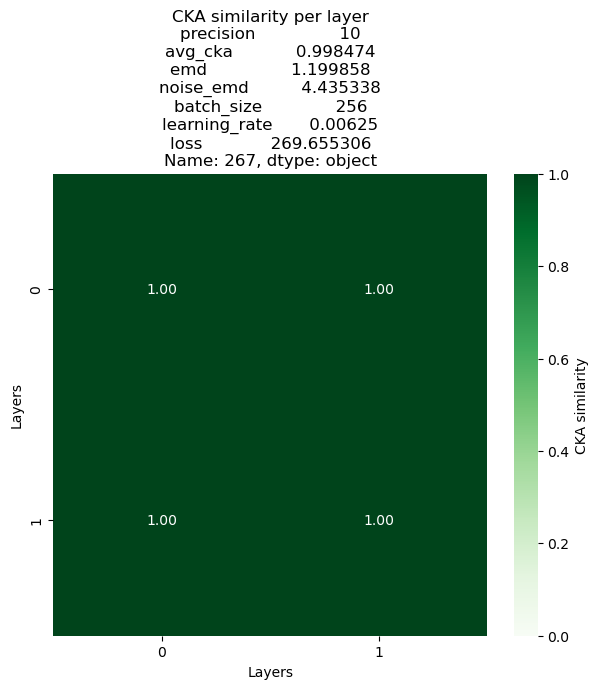

--------------------------------------------------------------------------------
Low loss
EMD:	1.2699809869130452
Loss:	273.59714379027014
AVG CKA similarity:	0.9515411853790283


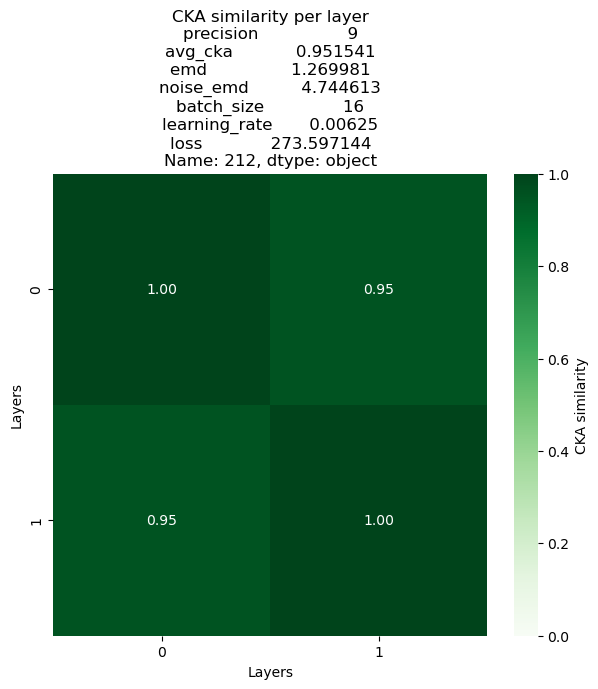

In [39]:
worst_df = cka_distribution_df.tail(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    
    path = os.path.join(
        DATA_PATH,
        f"bs{worst_df.iloc[i]['batch_size']}_lr{worst_df.iloc[i]['learning_rate']}" \
        f"/ECON_{worst_df.iloc[i]['precision']}b/{size}/"
    )
    cka = get_cka_per_model(int(worst_df.iloc[i]['batch_size']),
                            float(worst_df.iloc[i]['learning_rate']), 
                            int(worst_df.iloc[i]['precision']),
                            size,
                            cka_dataloader,
                            max_batches=cka_batch_num)
    if cka.load_from_file(path):
        results = cka.results
    else:
        results = cka.compute()
        
    print(f"EMD:\t{worst_df.iloc[i]['emd']}\n" \
          f"Loss:\t{worst_df.iloc[i]['loss']}\n" \
          f"AVG CKA similarity:\t{worst_df.iloc[i]['avg_cka']}")
    
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{worst_df.iloc[i]}", 
                    scale_label='CKA similarity')

In [40]:
# TODO: plot the distance in the space

# Jet Tagger (MLP)
The full precision model achieve 76% of accuracy.

In [41]:
DATA_PATH="/home/jovyan/checkpoint/"    
DATASET_DIR="../../data/JTAG"
DATASET_FILE=DATASET_DIR + "/processed_dataset.h5"

JTAG_layers = ['model.dense_1', 'model.dense_2', 'model.dense_3', 'model.dense_4']
# we do not consider extreme low precisions due to their performances
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [42]:
def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = JetDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # check if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module


def load_model(batch_size, learning_rate, precision):
    '''
    Method used to get the model and the relative accuracy
    '''
    accuracy, idx = get_model_index_and_relative_accuracy(batch_size, learning_rate, precision)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/net_{idx}_best.pkl'
    
    # load the model
    model = JetTagger(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((16, 16)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, accuracy


def get_model_index_and_relative_accuracy(batch_size, learning_rate, precision, num_tests=5):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    performances = []
    max_acc = 0
    max_acc_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'JTAG_{precision}b/accuracy_{i}.txt'
        try:
            jtag_file = open(file_path)
            jtag_text = jtag_file.read()
            accuracy = ast.literal_eval(jtag_text)
            accuracy = accuracy[0]['test_acc']
            performances.append(accuracy)
            if accuracy >= max_acc:
                max_acc = accuracy
                max_acc_index = i
            jtag_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(performances) == 0:
        # warnings.warn(f"Attention: There is no accuracy value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/JTAG_{precision}b")
        return
    
    return mean(performances), max_acc_index


def get_accuracy_with_noise(batch_size, learning_rate, precision, noise_type, percentage):
    '''
    Return the accuracy achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_{noise_type}_{percentage}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc


def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      dataloader,
                      activation_layers=ECON_layers,
                      max_batches=cka_batch_num):
    # load the model
    model, _ = load_model(batch_size, learning_rate, precision)
    
    # init the metric
    cka = CKA(model, 
              dataloader, 
              layers=activation_layers,
              max_batches=max_batches)
    
    return cka


def compute_distance(cka, batch_size, learning_rate, precision, load=True):
    # check if distance already computed
    if load:
        cka.name = f'distance_{size}_bs{batch_size}_lr{learning_rate}_p{precision}'
        if cka.load_from_file(DATA_PATH):
            return cka.results
        
    model, _ = load_model(batch_size, learning_rate, precision)
    # compute the difference
    result = cka.compare(model, cka.layers)
    cka.save_on_file(path=DATA_PATH)
    
    return result

## Result

In [43]:
# During the computation of the CKA similarity both the model must process the same data, 
# so we create a cka_dataloader equal for all the models which we will use to carry on our
# test
cka_dataloader = get_data_module(16).test_dataloader()

noise_type = 'gaussian'
noise = 5 # 5 10 15 20

Loaded shaped data shape (train): (630000, 16)
Loaded shaped data datatype (train): float32
Loaded shaped data shape (val): (240000, 16)
Loaded shaped data datatype (val): float32


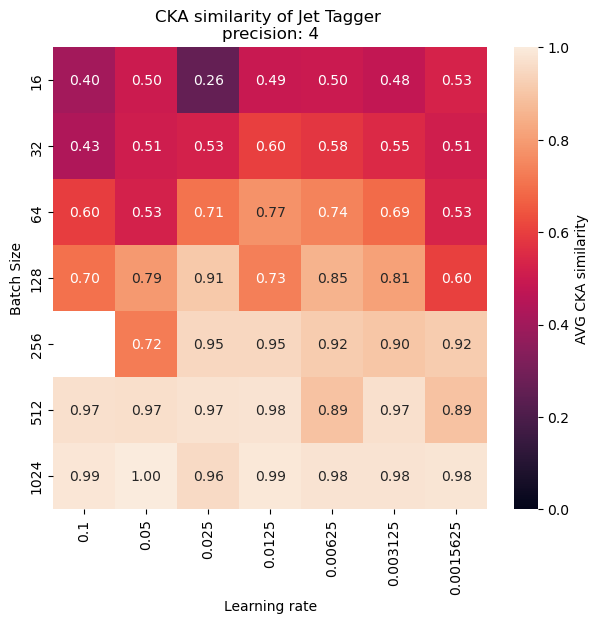

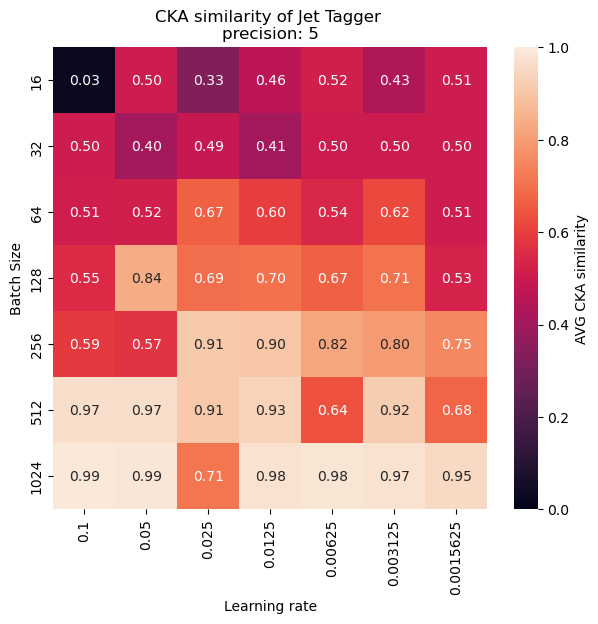

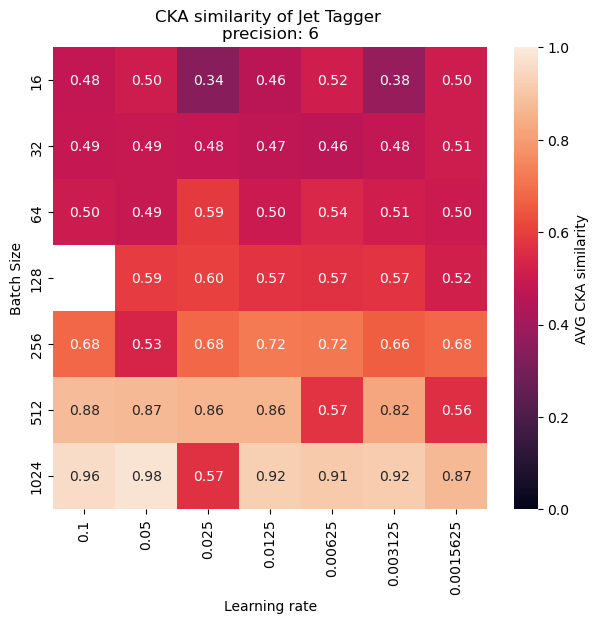

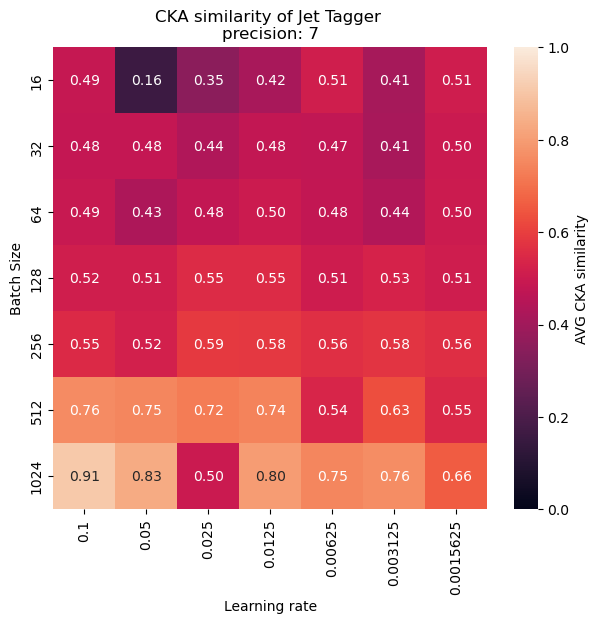

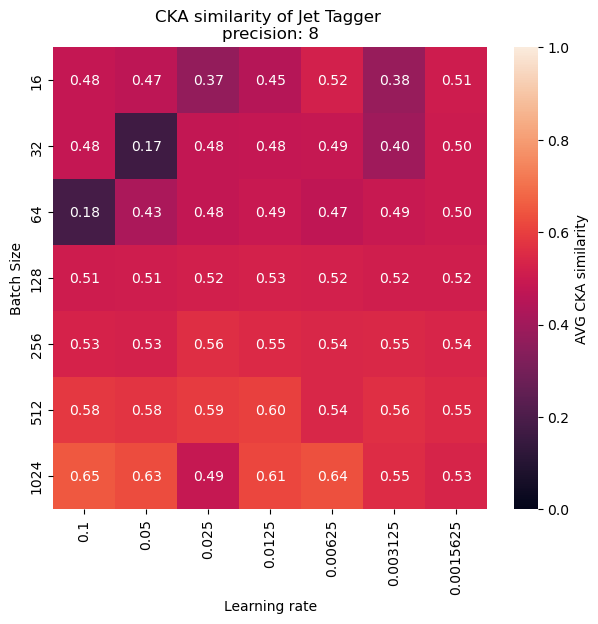

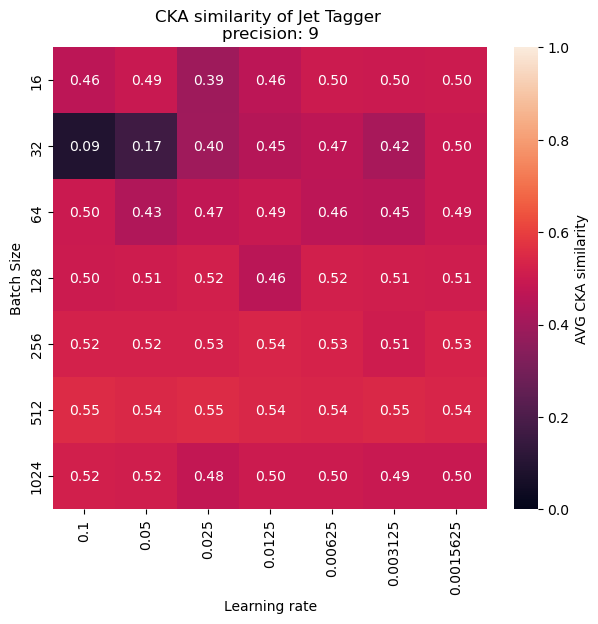

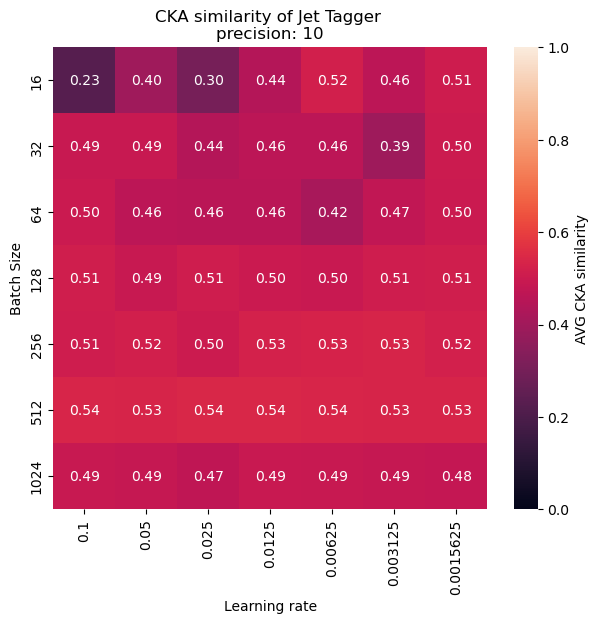

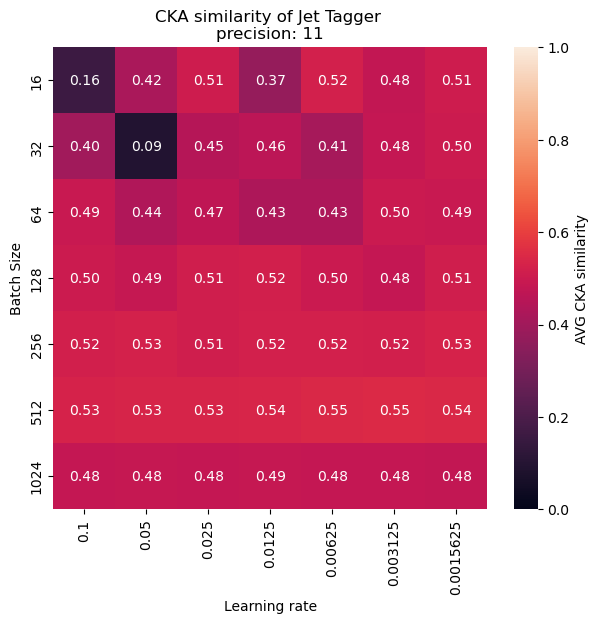

In [44]:
cka_distribution = []
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get the performance of the model with and without noise
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            noise_acc = get_accuracy_with_noise(bs, lr, p, noise_type, noise)
            # path to the directory
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/JTAG_{p}b/')
            # get the metric
            cka = get_cka_per_model(bs,
                                    lr,
                                    p,
                                    cka_dataloader,
                                    ECON_layers,
                                    max_batches=cka_batch_num)
            
            # load the results
            avg_cka = -1
            if cka.load_from_file(path):
                result = cka.results['internal_cka'].detach().cpu().numpy()
                avg_cka = (np.sum(result) - np.sum(result.diagonal())) \
                                / (result.shape[0]**2 - result.shape[0])

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
            # build the dataframe for further analysis
            cka_distribution.append({
                'precision': p, 
                'avg_cka': avg_cka,
                'accuracy': mean_acc,
                'noise_acc': noise_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (mean_acc - noise_acc) * 100 / mean_acc,
            })
            
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of Jet Tagger \nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity',
                    cmap='rocket')

In [45]:
cka_distribution_df = pd.DataFrame(cka_distribution)

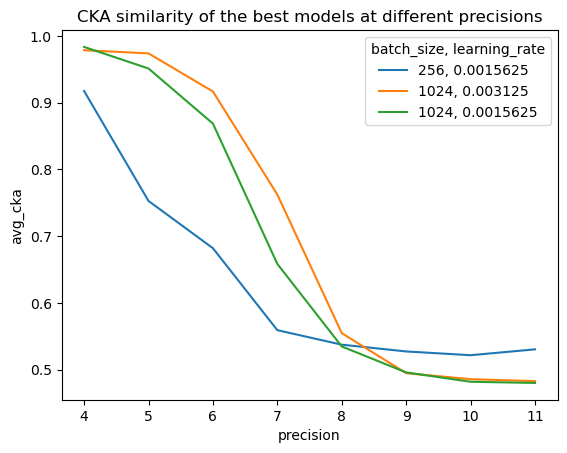

In [46]:
top_5_df = cka_distribution_df.loc[
        (cka_distribution_df.batch_size == '1024') & (cka_distribution_df.learning_rate == '0.0015625') |
        (cka_distribution_df.batch_size == '256') & (cka_distribution_df.learning_rate == '0.0015625') |
        (cka_distribution_df.batch_size == '256') & (cka_distribution_df.learning_rate == '0.0015625') |
        (cka_distribution_df.batch_size == '1024') & (cka_distribution_df.learning_rate == '0.0015625') |
        (cka_distribution_df.batch_size == '1024') & (cka_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='avg_cka', hue=hue)
plt.title("CKA similarity of the best models at different precisions")
plt.show()

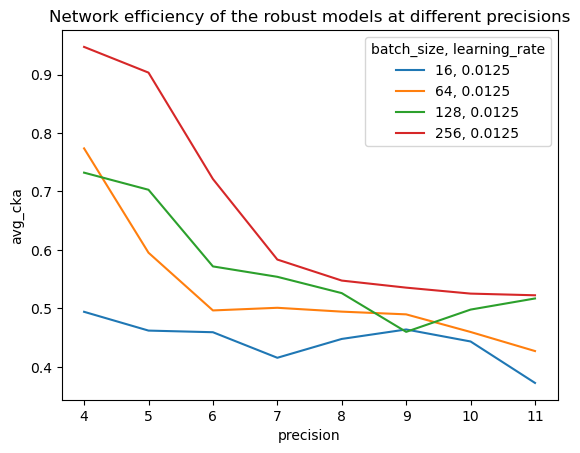

In [47]:
top_5_df = cka_distribution_df.loc[
        (cka_distribution_df.batch_size == '16') & (cka_distribution_df.learning_rate == '0.0125') |
        (cka_distribution_df.batch_size == '64') & (cka_distribution_df.learning_rate == '0.0125') |
        (cka_distribution_df.batch_size == '256') & (cka_distribution_df.learning_rate == '0.0125') |
        (cka_distribution_df.batch_size == '16') & (cka_distribution_df.learning_rate == '0.03125') |
        (cka_distribution_df.batch_size == '128') & (cka_distribution_df.learning_rate == '0.0125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='avg_cka', hue=hue)
plt.title("Network efficiency of the robust models at different precisions")
plt.show()

## Per layer analysis

In [50]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
NUM_PLOT = 3

cka_distribution_df = cka_distribution_df.loc[
        (cka_distribution_df.loss > -0.5) & 
        (cka_distribution_df.accuracy > MIN_ACCURACY) # &
        # (ne_distribution_df.loss < MAX_LOSS)
    ]
cka_distribution_df.sort_values(by='loss', ascending=True, inplace=True)

--------------------------------------------------------------------------------
Low loss
EMD:	0.7236066579818725
Loss:	0.03949883399691837
AVG CKA similarity:	0.46392520268758136


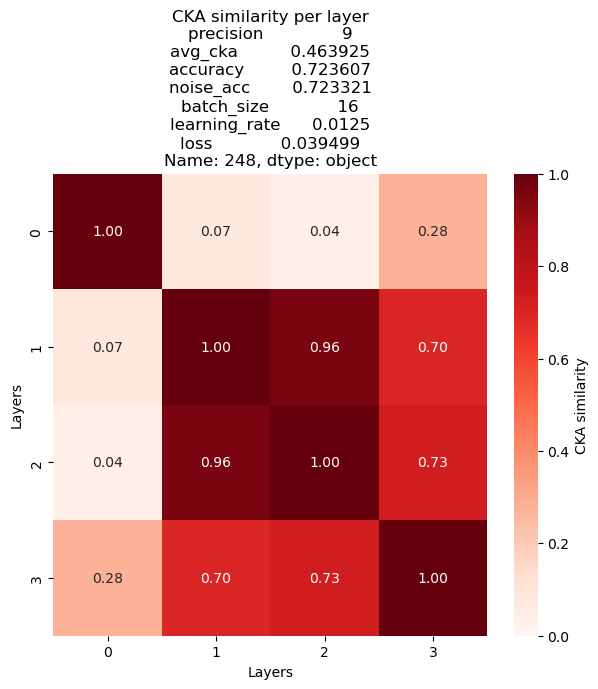

--------------------------------------------------------------------------------
Low loss
EMD:	0.7275750041007996
Loss:	0.329860290465477
AVG CKA similarity:	0.5868941148122152


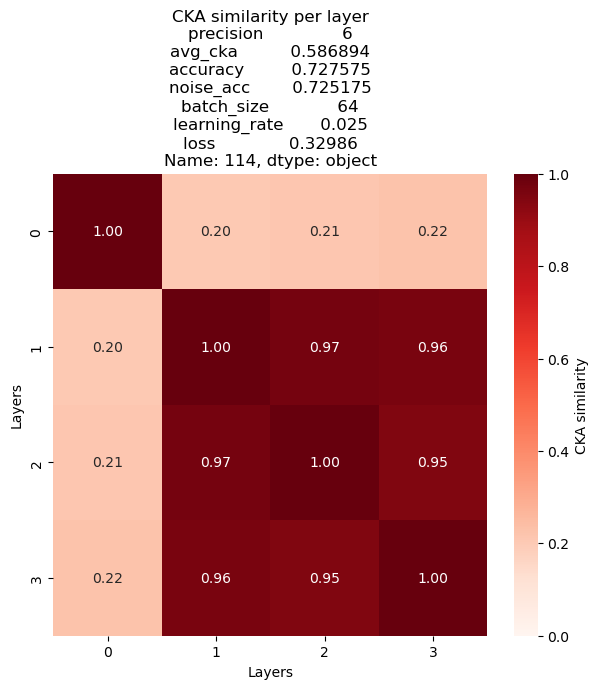

--------------------------------------------------------------------------------
Low loss
EMD:	0.724667489528656
Loss:	0.40201834148536963
AVG CKA similarity:	0.9473244349161783


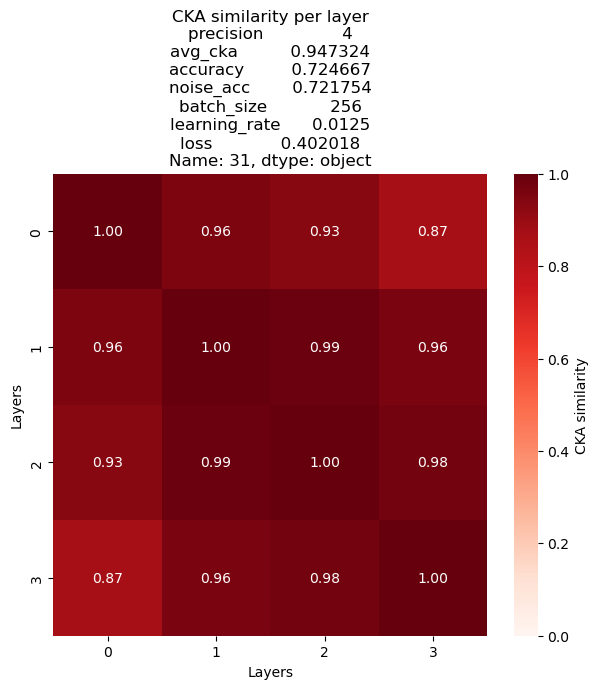

In [53]:
best_df = cka_distribution_df.head(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    
    path = os.path.join(
        DATA_PATH,
        f"bs{best_df.iloc[i]['batch_size']}_lr{best_df.iloc[i]['learning_rate']}" \
        f"/JTAG_{best_df.iloc[i]['precision']}b//"
    )
    cka = get_cka_per_model(int(best_df.iloc[i]['batch_size']),
                            float(best_df.iloc[i]['learning_rate']), 
                            int(best_df.iloc[i]['precision']),
                            cka_dataloader,
                            max_batches=cka_batch_num)
    if cka.load_from_file(path):
        results = cka.results
    else:
        results = cka.compute()
        
    print(f"Accuracy:\t{best_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{best_df.iloc[i]['loss']}\n" \
          f"AVG CKA similarity:\t{best_df.iloc[i]['avg_cka']}")
    
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{best_df.iloc[i]}", 
                    scale_label='CKA similarity')


--------------------------------------------------------------------------------
Low loss
accuracy:	0.760420823097229
Loss:	73.5820620453879
AVG CKA similarity:	0.4155755043029785


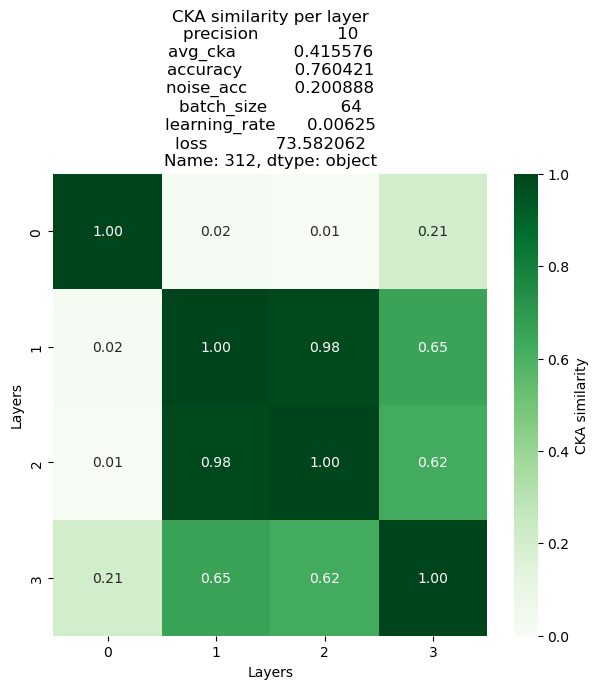

--------------------------------------------------------------------------------
Low loss
accuracy:	0.7595208406448364
Loss:	73.67528917779174
AVG CKA similarity:	0.4776167869567871


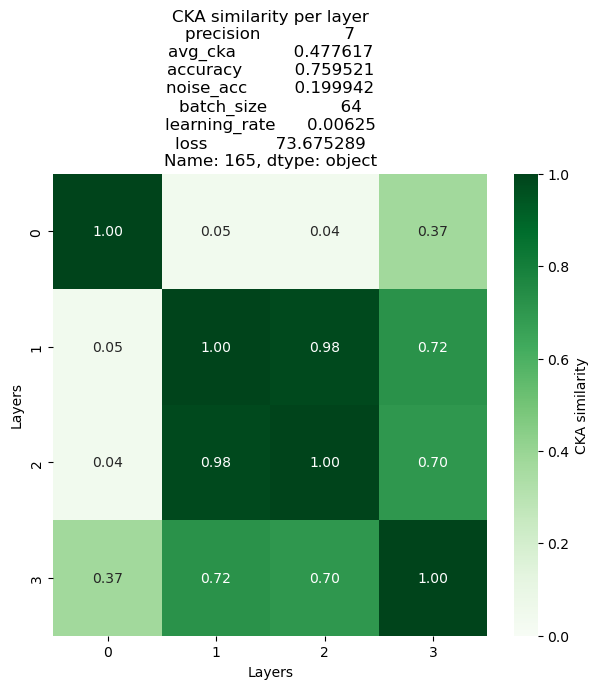

--------------------------------------------------------------------------------
Low loss
accuracy:	0.7611416697502136
Loss:	73.9585267415526
AVG CKA similarity:	0.42878182729085285


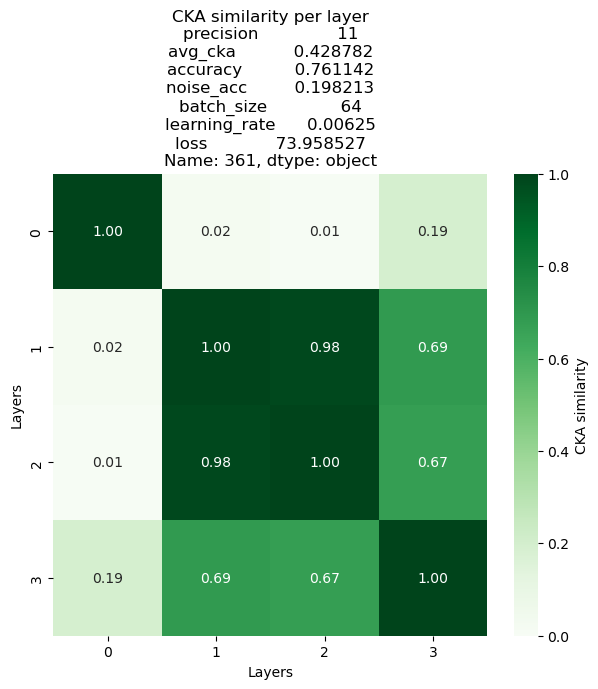

In [55]:
worst_df = cka_distribution_df.tail(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    
    path = os.path.join(
        DATA_PATH,
        f"bs{worst_df.iloc[i]['batch_size']}_lr{worst_df.iloc[i]['learning_rate']}" \
        f"/JTAG_{worst_df.iloc[i]['precision']}b/"
    )
    cka = get_cka_per_model(int(worst_df.iloc[i]['batch_size']),
                            float(worst_df.iloc[i]['learning_rate']), 
                            int(worst_df.iloc[i]['precision']),
                            cka_dataloader,
                            max_batches=cka_batch_num)
    if cka.load_from_file(path):
        results = cka.results
    else:
        results = cka.compute()
        
    print(f"accuracy:\t{worst_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{worst_df.iloc[i]['loss']}\n" \
          f"AVG CKA similarity:\t{worst_df.iloc[i]['avg_cka']}")
    
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{worst_df.iloc[i]}", 
                    scale_label='CKA similarity')

In [ ]:
# TODO: plot the distance in the space